##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tune PaliGemma for Image Description with Custom Dataset

This notebook guides you through the process of fine-tuning [PaliGemma](https://ai.google.dev/gemma/docs/paligemma), a powerful vision-language model, for bird description using [JAX](https://jax.readthedocs.io/en/latest/installation.html). We will leverage a curated subset of a bird species dataset and enrich it with descriptive text for each bird. The resulting dataset, comprising 3,692 image-description pairs, will be used to fine-tune PaliGemma, enabling it to generate accurate and detailed descriptions of bird images.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/PaliGemma/Finetune_PaliGemma_for_image_description.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup), or completing the following steps:

1. Log in to [Kaggle](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [Gemma model card](https://www.kaggle.com/models/google/paligemma/), as PaliGemma is a Gemma variant and click **Request Access**.
1. Complete the consent form and accept the terms and conditions.

To generate a Kaggle API key, open your [**Settings** page in Kaggle](https://www.kaggle.com/settings) and click **Create New Token**. This triggers the download of a `kaggle.json` file containing your API credentials.

Then, in Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the PaliGemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, click the **▾ (Additional connection options)** dropdown menu.
1. Select **Change runtime type**.
1. Under **Hardware accelerator**, select **T4 GPU**.

### Set environment variables for Kaggle API credentials

In [ ]:
import os
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

### Fetch the `big_vision` repository and install related dependencies

In [ ]:
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.3 MB/s eta 0:00:00


### Import JAX and other dependencies

Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [ ]:
# Import necessary libraries
import base64
import functools
import html
import io
import glob

import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

import pandas as pd
import random
import json

from IPython.core.display import display, HTML
from PIL import Image
import matplotlib.pyplot as plt

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.26
JAX platform: gpu
JAX devices:  1


## Download and configure the model


In [ ]:
import kagglehub

MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  # Note: kaggle archive contains the same checkpoint in multiple formats.
  # Download only the float16 model.
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.45G/5.45G [01:03<00:00, 91.8MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
- [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


# Prepare Dataset for Fine-tunning
Here, we process the bird image dataset and descriptions for use with PaliGemma.

1.  Curating the Dataset:

* The **525 Bird Species dataset** [(`gpiosenka/100-bird-species`)](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)from Kaggle contains a comprehensive collection of images representing various bird species. Each image is labeled with its corresponding bird species, providing diverse visual data for training and validation.

* **Bird Species Descriptions Dataset**: The Bird Species Description DataFrame [(`selamw/birds-discription-df`)](https://www.kaggle.com/datasets/selamw/birds-discription-df) complements the image dataset by providing textual descriptions for the first 23 out of the 525 bird species. This enriches our training data with descriptive text, facilitating a vision-language learning approach with PaliGemma.

2.  Downloading the Datasets from Kaggle:

* To obtain the datasets containing bird species images and their descriptions, download them directly from Kaggle using the following commands:


In [ ]:
! kaggle datasets download "gpiosenka/100-bird-species"
! kaggle datasets download "selamw/birds-discription-df"

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/100-bird-species
License(s): CC0-1.0
 99% 1.94G/1.96G [00:15<00:00, 242MB/s]
100% 1.96G/1.96G [00:15<00:00, 138MB/s]
Dataset URL: https://www.kaggle.com/datasets/selamw/birds-discription-df
License(s): Apache 2.0
  0% 0.00/24.2k [00:00<?, ?B/s]
100% 24.2k/24.2k [00:00<00:00, 45.8MB/s]


Unzip the dataset containing the images of bird species and descriptions:

In [ ]:
! unzip "100-bird-species.zip"
! unzip "birds-discription-df.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/WHITE TAILED TROPIC/122.jpg  
  inflating: train/WHITE TAILED TROPIC/123.jpg  
  inflating: train/WHITE TAILED TROPIC/124.jpg  
  inflating: train/WHITE TAILED TROPIC/125.jpg  
  inflating: train/WHITE TAILED TROPIC/126.jpg  
  inflating: train/WHITE TAILED TROPIC/127.jpg  
  inflating: train/WHITE TAILED TROPIC/128.jpg  
  inflating: train/WHITE TAILED TROPIC/129.jpg  
  inflating: train/WHITE TAILED TROPIC/130.jpg  
  inflating: train/WHITE TAILED TROPIC/131.jpg  
  inflating: train/WHITE TAILED TROPIC/132.jpg  
  inflating: train/WHITE TAILED TROPIC/133.jpg  
  inflating: train/WHITE TAILED TROPIC/134.jpg  
  inflating: train/WHITE TAILED TROPIC/135.jpg  
  inflating: train/WHITE TAILED TROPIC/136.jpg  
  inflating: train/WHITE TAILED TROPIC/137.jpg  
  inflating: train/WHITE TAILED TROPIC/138.jpg  
  inflating: train/WHITE TAILED TROPIC/139.jpg  
  inflating: train/WHITE TAILED TROPIC/140.jpg  
  inflating: train

In [ ]:
# Verify the extracted files
%ls

 100-bird-species.zip    birds-discription-df.zip                    test/
 big_vision_repo/       'EfficientNetB0-525-(224 X 224)- 98.97.h5'   train/
 birds.csv               paligemma_tokenizer.model                   valid/
 birds_description.csv   sample_data/


## Load and display the bird descriptions dataset:

In [ ]:
# Load the descriptions DataFrame
birds_discription_df = pd.read_csv("birds_description.csv")
birds_discription_df

,class id,filepaths,labels,data set,scientific name,bird_description
0,0.0,ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI,Abbott's Babbler: Look for this small insectiv...
1,0.0,ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI,Abbott's Babbler: Look for this small insectiv...
2,0.0,ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI,Abbott's Babbler: Look for this small insectiv...
3,0.0,ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI,Abbott's Babbler: Look for this small insectiv...
4,0.0,ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI,Abbott's Babbler: Look for this small insectiv...
...,...,...,...,...,...,...
3917,524.0,BLACK BREASTED PUFFBIRD/3.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS,Black-breasted Puffbird: Observe the medium-si...
3918,524.0,BLACK BREASTED PUFFBIRD/4.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS,Black-breasted Puffbird: Observe the medium-si...
3919,524.0,BLACK BREASTED PUFFBIRD/1.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS,Black-breasted Puffbird: Observe the medium-si...
3920,524.0,BLACK BREASTED PUFFBIRD/2.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS,Black-breasted Puffbird: Observe the medium-si...


### Display number of unique species, number of training and validation samples

In [ ]:
print("Number of unique bird species:", len(birds_discription_df['labels'].unique()))
print("Number of training samples:", (birds_discription_df['data set'] == "train").sum())
print("Number of validation samples:", (birds_discription_df['data set'] == "valid").sum())

Number of unique bird species: 23
Number of training samples: 3692
Number of validation samples: 115


## Convert DataFrame to JSON Lines for Finetuning

Since PaliGemma expects data in JSON Lines format for finetuning, we convert the DataFrame containing bird information into separate JSON Lines files for training and validation data.

For fine-tuning, we only need two columns from the DataFrame:

* `"filepaths"`: This column contains the paths to the bird images.
* `"bird_description"`: This column contains descriptions for each bird species.

In [ ]:
def df_to_jsonl(df):
    """Converts a pandas DataFrame to separate JSON Lines files for train and validation data.

    Args:
      df: The pandas DataFrame to convert.

    Returns:
      None. Writes the JSON Lines to separate 'train.jsonl' and 'valid.jsonl' files.
    """

    train_file = open('train.jsonl', 'w')
    valid_file = open('valid.jsonl', 'w')

    try:
        for index, row in df.iterrows():
            if row['data set'] == 'train':
                data = {
                    'prefix': '',
                    'suffix': row['bird_description'],
                    'image': row['filepaths']
                }
                json.dump(data, train_file)
                train_file.write('\n')
            elif row['data set'] == 'valid':
                data = {
                    'prefix': '',
                    'suffix': row['bird_description'],
                    'image': row['filepaths']
                }
                json.dump(data, valid_file)
                valid_file.write('\n')

    finally:
        train_file.close()
        valid_file.close()

        print("DataFrame converted to JSON Lines format and saved to train.jsonl and valid.jsonl")

# Convert the birds description DataFrame to JSON Lines format
df_to_jsonl(birds_discription_df)


DataFrame converted to JSON Lines format and saved to train.jsonl and valid.jsonl


## Display first record from JSON lines file

In [ ]:
def display_first_record(filename):
    """Opens a JSON Lines file and displays only the first record.

    Args:
        filename: The path to the JSON Lines file.
    """
    try:
        with open(filename, 'r') as f:
            first_line = f.readline().strip()
            if first_line:  # Check if there's data in the file
                data = json.loads(first_line)
                print(f"First Record:\n{json.dumps(data, indent=2)}")
            else:
                print("File is empty or corrupt.")
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")

# Display the first record in 'train.jsonl'
display_first_record('train.jsonl')

First Record:
{
  "prefix": "",
  "suffix": "Abbott's Babbler: Look for this small insectivorous bird with distinctive streaked brown plumage and pale buff underparts, making its home in the diverse landscapes of South Asia.",
  "image": "ABBOTTS BABBLER/001.jpg"
}


# Download and configure PaliGemma model
This section retrieves the pre-trained model and tokenizer weights.

In [ ]:
# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in a notebook.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU/TPU memory

In [ ]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the notebook runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

# Prepare to tune the model

In [ ]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


### Create the training and validation iterators

In [ ]:
SEQLEN = 128

TRAIN_DATA_DIR = 'train/'
VALID_DATA_DIR = 'valid/'

# Load training data
train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join("train.jsonl"),
    fopen_keys={"image": TRAIN_DATA_DIR})

# Load validation data
val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join("valid.jsonl"),
    fopen_keys={"image": VALID_DATA_DIR})

def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    # Define prefix for tokenization
    prefix = "describe en"
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    # Define prefix for tokenization
    prefix = "describe en"  # Could also be a different prefix per example 'describe en'
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


### View sample training examples

Training Examples



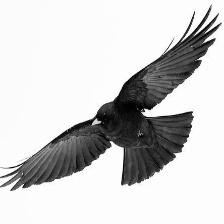
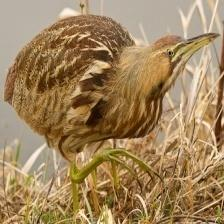
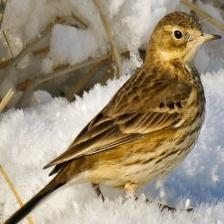
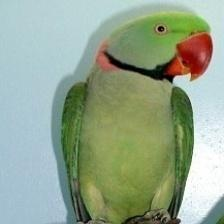
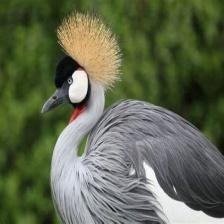
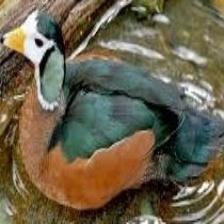
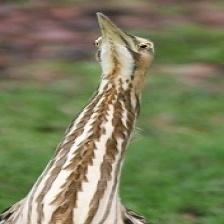
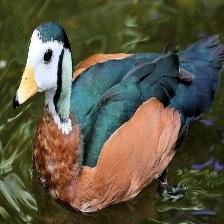

In [ ]:
def render_inline(image, resize=(128, 128)):
  """Converts an image array into inline HTML.

  Args:
    image (numpy.ndarray): The image array to convert.
    resize (tuple): Optional. Size to resize the image to before conversion. Default is (128, 128).

  Returns:
    str: HTML representation of the image encoded in base64.
  """
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, description):
  """Generates HTML for displaying an image with its description.

  Args:
    image (numpy.ndarray): The image array to display.
    description (str): The description of the image.

  Returns:
    str: HTML representation of the image with description.
  """
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(description)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
    description = postprocess_tokens(example["text"])  # detokenize model input.
    description = description[len("describe en\n"):]
    html_out += render_example(example["image"], description)

print("Training Examples")
display(HTML(html_out))

### Define the training and evaluation loops

In [ ]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  """Performs one update step using stochastic gradient descent (SGD).

  Args:
      params (dict): Current model parameters.
      batch (dict): Batch of data containing images, texts, and masks.
      learning_rate (float): Learning rate for the update.

  Returns:
      tuple: Updated parameters and the calculated loss.
  """

  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  """Generates model predictions for given data iterator.

  Args:
      data_iterator (iterator): Iterator yielding batches of data.
      num_examples (int, optional): Maximum number of examples to generate predictions for.
      batch_size (int, optional): Batch size for inference. Default is 4.
      seqlen (int, optional): Maximum sequence length for decoding. Default is SEQLEN.
      sampler (str, optional): Sampling method for generating predictions. Default is "greedy".

  Returns:
      list: List of tuples containing image and corresponding model response.
  """
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]


    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

# Finetune the model

step:  1/128   lr: 0.00005   loss: 3.5541
step:  2/128   lr: 0.00009   loss: 3.2215
step:  3/128   lr: 0.00014   loss: 3.7010
step:  4/128   lr: 0.00019   loss: 3.2698
step:  5/128   lr: 0.00023   loss: 3.5187
step:  6/128   lr: 0.00028   loss: 3.3232
step:  7/128   lr: 0.00033   loss: 3.2168
step:  8/128   lr: 0.00038   loss: 3.2819
step:  9/128   lr: 0.00042   loss: 3.2132
step: 10/128   lr: 0.00047   loss: 3.2118
step: 11/128   lr: 0.00052   loss: 3.1371
step: 12/128   lr: 0.00056   loss: 3.1616
step: 13/128   lr: 0.00061   loss: 3.5072
step: 14/128   lr: 0.00066   loss: 2.9888
step: 15/128   lr: 0.00070   loss: 3.2852
step: 16/128   lr: 0.00075   loss: 3.1900
step: 17/128   lr: 0.00080   loss: 3.1098
step: 18/128   lr: 0.00084   loss: 3.0129
step: 19/128   lr: 0.00089   loss: 3.0052
step: 20/128   lr: 0.00094   loss: 2.9630
step: 21/128   lr: 0.00098   loss: 2.8648
step: 22/128   lr: 0.00103   loss: 2.9091
step: 23/128   lr: 0.00108   loss: 2.7960
step: 24/128   lr: 0.00112   loss:

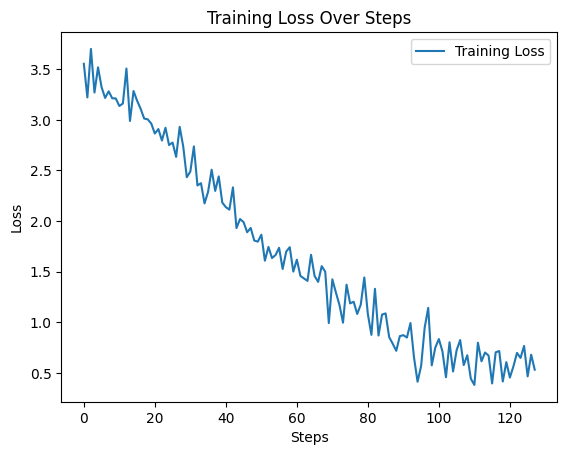

In [ ]:
# Fine-tune the model parameters.
BATCH_SIZE = 4
TRAIN_EXAMPLES = 512
LEARNING_RATE = 0.003

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 4 # Number of evaluation steps

# Lists to store training losses
losses = []
train_data_it = train_data_iterator()

# Learning rate schedule using cosine decay with warmup
sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.50)

# Perform training steps
for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  losses.append(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

# Plotting the loss graph
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions and Validation Comparison

Predictions and Validation Examples: 10 Randomly Selected Images 




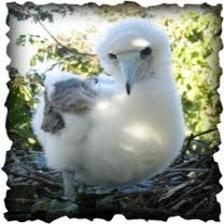
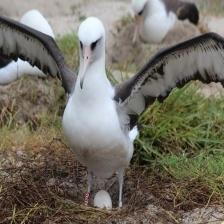
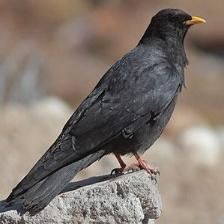
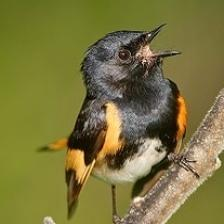
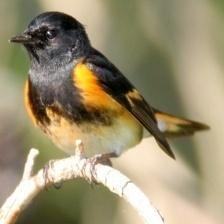
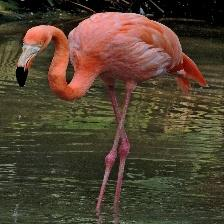
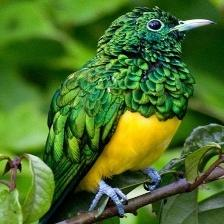
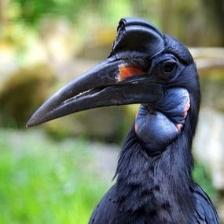
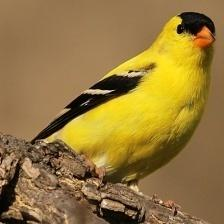
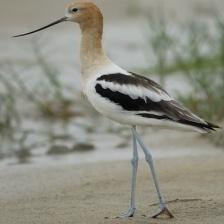

In [ ]:
def data_iterator(data_type=None):
    """Iterates over examples for validation or prediction.

    Args:
        data_type (str): Type of data to iterate ('prediction' or 'validation').

    Yields:
        dict: Dictionary containing image and text data based on data_type.
              For 'prediction': {'image': np.array, 'text': np.array, 'mask_ar': np.array, 'mask_input': np.array}
              For 'validation': {'image': np.array, 'text': np.array, 'mask_ar': np.array, 'mask_loss': np.array}
    """
    for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))
        image = preprocess_image(image)

        prefix = "describe en"
        if data_type == "prediction":
            tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

            yield {
                "image": np.asarray(image),
                "text": np.asarray(tokens),
                "mask_ar": np.asarray(mask_ar),
                "mask_input": np.asarray(mask_input),
            }
        elif data_type == "validation":
            suffix = example["suffix"].decode().lower()
            tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

            yield {
                "image": np.asarray(image),
                "text": np.asarray(tokens),
                "mask_ar": np.asarray(mask_ar),
                "mask_loss": np.asarray(mask_loss),
            }

def render_example(image, description):
  """Renders an image with description in HTML format.

  Args:
      image (np.array): Image data as numpy array.
      description (str): Description text to display alongside the image.

  Returns:
      str: HTML formatted string for displaying the image and description.
  """
  image = ((image + 1) / 2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center;">
    <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
  </div>
  """

def display_comparisons(predictions, validations):
  """Displays side-by-side comparisons of predictions and validations.

  Args:
      predictions (list): List of tuples (image, description) for predictions.
      validations (list): List of tuples (image, description) for validations.

  Prints:
      Displays HTML output showing 10 randomly selected images with predictions and validations.
  """
  html_out = ""

  # Select 10 random indices
  num_comparisons = min(10, len(predictions), len(validations))
  random_indices = random.sample(range(min(len(predictions), len(validations))), num_comparisons)

  for random_index in random_indices:
    pred_image, pred_description = predictions[random_index]
    val_image, val_description = validations[random_index]

    # Call render_example to get image content with description
    pred_content = render_example(pred_image, f"<b>Prediction:</b> {pred_description}")
    val_content = render_example(val_image, f"<b>Validation:</b> {val_description}")

    # Structure container with three columns and set widths
    html_out += f"""
      <div style="display: flex; border-bottom: 1px solid #ddd; padding: 5px;">
        <div style="width: 50%;"><b>Prediction:</b> {pred_description}</div>
        <div style="width: 128px; padding-right: 10px;">{pred_content}</div>
        <div style="width: 50%;"><b>Validation:</b> {val_description}</div>
      </div>
    """
  display(HTML(html_out))


# Generate predictions and validations
predictions = []
for image, description_pred in make_predictions(data_iterator("prediction"), batch_size=4):
  # Only append if both image and description_pred are not None
  if image is not None and description_pred is not None:
    predictions.append((image, description_pred))

validations = []
for example in data_iterator("validation"):
    description = postprocess_tokens(example["text"])
    description = description[len("describe en\n"):]  # Strip prefix describe the image
    # Only append if image and description are not None
    if example["image"] is not None and description is not None:
        validations.append((example["image"], description))

# Display predictions and validations side-by-side
print("Predictions and Validation Examples: 10 Randomly Selected Images \n")
display_comparisons(predictions, validations)

# Conclusion

This notebook fine-tuned PaliGemma on 3,692 image-description pairs from a diverse bird species dataset. Using 23 curated species with text descriptions, the model generally produced accurate descriptions similar to validation data. However, improvements are needed for better species identification accuracy, suggesting potential benefits from expanding training to include more of the 525 available species.

# Reference
- [Fine-tune PaliGemma with JAX](https://www.kaggle.com/code/nilaychauhan/fine-tune-paligemma-with-jax)
- [PaliGemma model README](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
- [BIRDS 525 SPECIES- IMAGE CLASSIFICATION](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)